# Segmentation

## Configuration

First we install the necessary python libraries

In [1]:
# !pip install gluoncv --pre
# !pip install mxnet-cu90 --pre

We also need to download the Pascal VOC dataset for our training demonstration later.

In [2]:
# !python pascal_voc.py

In [3]:
import random
import matplotlib.image as mpimg
from datetime import datetime

import numpy as np
import mxnet as mx
from mxnet import image, autograd
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import viz
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from gluoncv.utils.parallel import *

ctx = mx.gpu(0)

## Segmentation with pre-trained models

We first download an image for the demo

In [4]:
url = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/segmentation/voc_examples/1.jpg'
filename = 'example.jpg'
gluoncv.utils.download(url, filename)
input_img = image.imread(filename)

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (15, 9)

viz.plot_image(input_img)
plt.show()

<Figure size 1500x900 with 1 Axes>

Next we define the transformation functions. It is just transformation and normalization.

In [5]:
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])
img = transform_fn(input_img)
img = img.expand_dims(0).as_in_context(ctx)
img.shape

(1, 3, 400, 500)

We'll use the pre-trained model `fcn_resnet101_voc`.

In [6]:
net = gluoncv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True, ctx=ctx)

Note we call `net.demo` here to make prediction.

In [7]:
output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

With the prediction, we can extract the mask and check how it works.

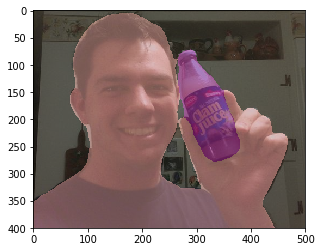

In [8]:
mask = viz.get_color_pallete(predict, 'pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

Next, let's try a more difficult image.

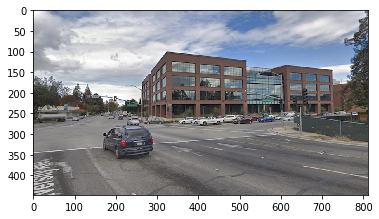

In [9]:
filename = 'streetview_amazon.png'
input_img = image.imread(filename)
img = transform_fn(input_img)
img = img.expand_dims(0).as_in_context(ctx)

viz.plot_image(input_img)
plt.show()

The image is larger thus takes a bit more time to predict.

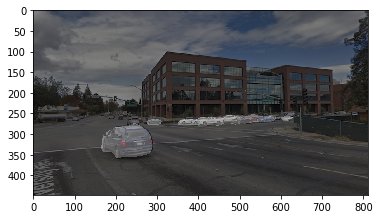

In [10]:
output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = viz.get_color_pallete(predict, 'pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

We merely see anything. This is because the dataset Pascal VOC doesn't have too much labels for the objects in the above image.

Instead, we use another model pre-trained on the dataset ADE20k.

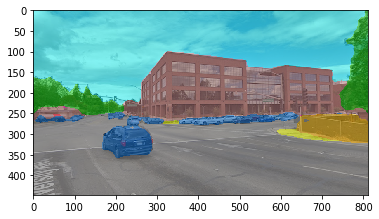

In [11]:
net = gluoncv.model_zoo.get_model('fcn_resnet50_ade', pretrained=True, ctx=ctx)
output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = viz.get_color_pallete(predict, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

How about an even more difficult one?

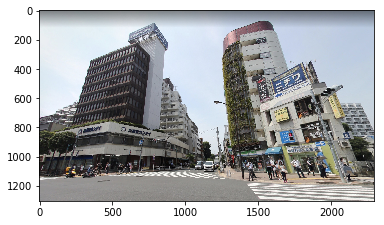

In [12]:
filename = 'streetview_meguro.jpg'
input_img = image.imread(filename)
img = transform_fn(input_img)
img = img.expand_dims(0).as_in_context(ctx)

viz.plot_image(input_img)
plt.show()

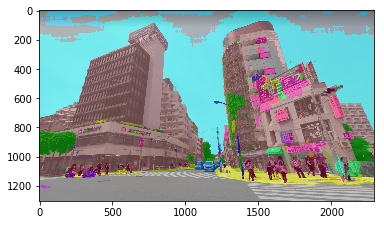

In [13]:
output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = viz.get_color_pallete(predict, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

Our model `fcn_resnet50_ade` overfits the sky, and is confused by the plant on the wall.

Let's try a larger one: `deeplab_resnet101_ade`.

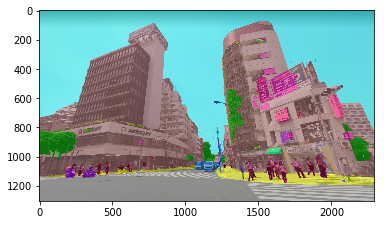

In [14]:
net = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True, ctx=ctx)
output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = viz.get_color_pallete(predict, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

It is much cleaner. Although it is still a bit confused by the plant on the wall.

Remember, choose your pre-trained model based on the data.

## Training on VOC

Let's start the training of a small network `fcn_resnet50_voc`. This time we don't start from a pre-trained model, but instead we start from a randomly initialized one.

You may increase the training process to see how the quality improved.

First, let's load the model without pretrained weight.

In [15]:
net = gluoncv.model_zoo.get_model('fcn_resnet50_voc', pretrained=False)

Come back to the first image, how does the output looks like?

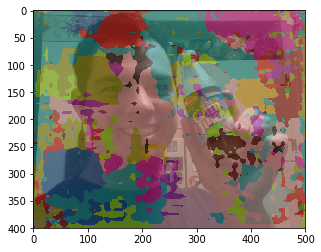

In [16]:
input_img = image.imread('example.jpg')
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])
img = transform_fn(input_img)
img = img.expand_dims(0)

output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
mask = viz.get_color_pallete(predict, 'pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

It is just random noise.

Notice: after called `net.demo()`, we need to re-define the size of `net`'s output. 

Because by calling `net.demo()` we changed the size to match the input image's, while during training `net` need a 480x480 output size.

In [17]:
from mxnet.gluon.data.vision import transforms
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])
net._up_kwargs['height'] = 480
net._up_kwargs['width'] = 480

Next we prepare the training data.

In [18]:
trainset = gluoncv.data.VOCSegmentation(split='train', transform=input_transform)
print('Training images:', len(trainset))
# set batch_size = 2 for toy example
batch_size = 4*4
# Create Training Loader
train_data = mx.gluon.data.DataLoader(
    trainset, batch_size, shuffle=True, last_batch='rollover',
    num_workers=batch_size)

Training images: 2913


We randomly sample an image and its mask. This is the usual format for most segmentation training tasks.

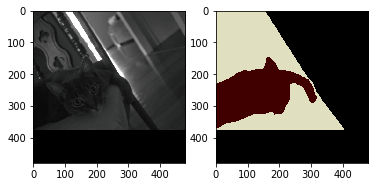

In [19]:
random.seed(datetime.now())
idx = random.randint(0, len(trainset))
img, mask = trainset[idx]
# get color pallete for visualize mask
mask = viz.get_color_pallete(mask.asnumpy(), dataset='pascal_voc')
mask.save('mask.png')
# denormalize the image
img = viz.DeNormalize([.485, .456, .406], [.229, .224, .225])(img)
img = np.transpose((img.asnumpy()*255).astype(np.uint8), (1, 2, 0))

# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)

plt.imshow(img)
# subplot 2 for the mask
mmask = mpimg.imread('mask.png')
fig.add_subplot(1,2,2)
plt.imshow(mmask)
# display
plt.show()

Next we define the loss, learning rate schedule.

In [20]:
criterion = MixSoftmaxCrossEntropyLoss(aux=True)
lr_scheduler = gluoncv.utils.LRScheduler(mode='poly', baselr=0.0001, niters=len(train_data),
                                         nepochs=50)

We use the `DataParallel` interface for model and loss computation. This is useful when Synchronized BatchNorm training is necessary.

In [21]:
ctx_list = [mx.gpu(i) for i in range(4)]
net = DataParallelModel(net, ctx_list)
criterion = DataParallelCriterion(criterion, ctx_list)

Next we define the optimizer.

In [22]:

optimizer = mx.gluon.Trainer(net.module.collect_params(), 'sgd',
                             {'lr_scheduler': lr_scheduler,
                              'wd':0.0001,
                              'momentum': 0.9,
                              'multi_precision': True})

Now we can start to train!

Remember that due to time limit we will not train until it converges.

However even by only 5 epochs' training, the result starts to make sense.

In [23]:
for epoch in range(5):
    train_loss = 0.0
    for i, (data, target) in enumerate(train_data):
        lr_scheduler.update(i, epoch)
        with autograd.record(True):
            outputs = net(data)
            losses = criterion(outputs, target)
            mx.nd.waitall()
            autograd.backward(losses)
        optimizer.step(batch_size)
        for loss in losses:
            train_loss += loss.asnumpy()[0] / len(losses)
        print('Epoch %d, batch %d, training loss %.3f'%(epoch, i, train_loss/(i+1)))

Epoch 0, batch 0, training loss 3.903
Epoch 0, batch 1, training loss 3.977
Epoch 0, batch 2, training loss 3.932
Epoch 0, batch 3, training loss 3.929
Epoch 0, batch 4, training loss 3.906
Epoch 0, batch 5, training loss 3.893
Epoch 0, batch 6, training loss 3.852
Epoch 0, batch 7, training loss 3.848
Epoch 0, batch 8, training loss 3.837
Epoch 0, batch 9, training loss 3.821
Epoch 0, batch 10, training loss 3.787
Epoch 0, batch 11, training loss 3.770
Epoch 0, batch 12, training loss 3.752
Epoch 0, batch 13, training loss 3.708
Epoch 0, batch 14, training loss 3.645
Epoch 0, batch 15, training loss 3.627
Epoch 0, batch 16, training loss 3.604
Epoch 0, batch 17, training loss 3.584
Epoch 0, batch 18, training loss 3.558
Epoch 0, batch 19, training loss 3.537
Epoch 0, batch 20, training loss 3.530
Epoch 0, batch 21, training loss 3.507
Epoch 0, batch 22, training loss 3.476
Epoch 0, batch 23, training loss 3.450
Epoch 0, batch 24, training loss 3.443
Epoch 0, batch 25, training loss 3.

Epoch 1, batch 27, training loss 1.592
Epoch 1, batch 28, training loss 1.633
Epoch 1, batch 29, training loss 1.624
Epoch 1, batch 30, training loss 1.624
Epoch 1, batch 31, training loss 1.619
Epoch 1, batch 32, training loss 1.607
Epoch 1, batch 33, training loss 1.589
Epoch 1, batch 34, training loss 1.592
Epoch 1, batch 35, training loss 1.595
Epoch 1, batch 36, training loss 1.627
Epoch 1, batch 37, training loss 1.622
Epoch 1, batch 38, training loss 1.622
Epoch 1, batch 39, training loss 1.645
Epoch 1, batch 40, training loss 1.624
Epoch 1, batch 41, training loss 1.630
Epoch 1, batch 42, training loss 1.631
Epoch 1, batch 43, training loss 1.640
Epoch 1, batch 44, training loss 1.635
Epoch 1, batch 45, training loss 1.640
Epoch 1, batch 46, training loss 1.640
Epoch 1, batch 47, training loss 1.658
Epoch 1, batch 48, training loss 1.647
Epoch 1, batch 49, training loss 1.656
Epoch 1, batch 50, training loss 1.647
Epoch 1, batch 51, training loss 1.661
Epoch 1, batch 52, traini

Epoch 2, batch 54, training loss 1.702
Epoch 2, batch 55, training loss 1.696
Epoch 2, batch 56, training loss 1.687
Epoch 2, batch 57, training loss 1.691
Epoch 2, batch 58, training loss 1.679
Epoch 2, batch 59, training loss 1.667
Epoch 2, batch 60, training loss 1.666
Epoch 2, batch 61, training loss 1.677
Epoch 2, batch 62, training loss 1.659
Epoch 2, batch 63, training loss 1.660
Epoch 2, batch 64, training loss 1.652
Epoch 2, batch 65, training loss 1.657
Epoch 2, batch 66, training loss 1.658
Epoch 2, batch 67, training loss 1.668
Epoch 2, batch 68, training loss 1.656
Epoch 2, batch 69, training loss 1.650
Epoch 2, batch 70, training loss 1.666
Epoch 2, batch 71, training loss 1.664
Epoch 2, batch 72, training loss 1.651
Epoch 2, batch 73, training loss 1.665
Epoch 2, batch 74, training loss 1.660
Epoch 2, batch 75, training loss 1.661
Epoch 2, batch 76, training loss 1.654
Epoch 2, batch 77, training loss 1.671
Epoch 2, batch 78, training loss 1.668
Epoch 2, batch 79, traini

Epoch 3, batch 81, training loss 1.601
Epoch 3, batch 82, training loss 1.608
Epoch 3, batch 83, training loss 1.611
Epoch 3, batch 84, training loss 1.617
Epoch 3, batch 85, training loss 1.612
Epoch 3, batch 86, training loss 1.615
Epoch 3, batch 87, training loss 1.609
Epoch 3, batch 88, training loss 1.609
Epoch 3, batch 89, training loss 1.609
Epoch 3, batch 90, training loss 1.620
Epoch 3, batch 91, training loss 1.626
Epoch 3, batch 92, training loss 1.628
Epoch 3, batch 93, training loss 1.625
Epoch 3, batch 94, training loss 1.621
Epoch 3, batch 95, training loss 1.625
Epoch 3, batch 96, training loss 1.626
Epoch 3, batch 97, training loss 1.628
Epoch 3, batch 98, training loss 1.641
Epoch 3, batch 99, training loss 1.641
Epoch 3, batch 100, training loss 1.635
Epoch 3, batch 101, training loss 1.629
Epoch 3, batch 102, training loss 1.622
Epoch 3, batch 103, training loss 1.617
Epoch 3, batch 104, training loss 1.621
Epoch 3, batch 105, training loss 1.625
Epoch 3, batch 106,

Epoch 4, batch 108, training loss 1.491
Epoch 4, batch 109, training loss 1.493
Epoch 4, batch 110, training loss 1.490
Epoch 4, batch 111, training loss 1.483
Epoch 4, batch 112, training loss 1.488
Epoch 4, batch 113, training loss 1.492
Epoch 4, batch 114, training loss 1.487
Epoch 4, batch 115, training loss 1.495
Epoch 4, batch 116, training loss 1.507
Epoch 4, batch 117, training loss 1.501
Epoch 4, batch 118, training loss 1.507
Epoch 4, batch 119, training loss 1.508
Epoch 4, batch 120, training loss 1.510
Epoch 4, batch 121, training loss 1.521
Epoch 4, batch 122, training loss 1.518
Epoch 4, batch 123, training loss 1.520
Epoch 4, batch 124, training loss 1.525
Epoch 4, batch 125, training loss 1.523
Epoch 4, batch 126, training loss 1.524
Epoch 4, batch 127, training loss 1.526
Epoch 4, batch 128, training loss 1.523
Epoch 4, batch 129, training loss 1.524
Epoch 4, batch 130, training loss 1.528
Epoch 4, batch 131, training loss 1.526
Epoch 4, batch 132, training loss 1.527


Let's re-predict on the image we used.

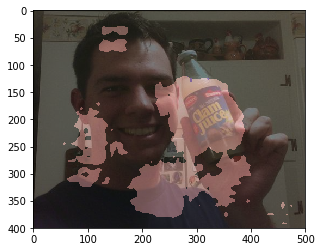

In [24]:
input_img = image.imread('example.jpg')
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])
img = transform_fn(input_img)
img = img.expand_dims(0).as_in_context(mx.gpu(0))

output = net.module.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
mask = viz.get_color_pallete(predict, 'pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

Although this is a small example, it is basically how we train a model on much larger dataset.

## Further resources

On the [GluonCV Segmentation Model Zoo](https://gluon-cv.mxnet.io/model_zoo/segmentation.html) page, we provide:

- Training scripts for FCN/PSPnet/DeepLab/Mask R-CNN on MS COCO/Pascal VOC/Cityscapes.
- Training hyperparameters to reproduce.
- Training Logs to compare speed and accuracy.